In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import os
from itertools import product
import numpy as np
import re

In [2]:
from min_bisection import solution_schema

In [3]:
root_fldr = 'runs\\v0.5'

In [6]:
def subdir_paths(folder):
    return [os.path.join(folder, f) for f in next(os.walk(folder))[1] if f != 'profiles']

meta_dfs = []
run_dfs = []
fldrs = subdir_paths(root_fldr)
for fldr in fldrs:
    print(fldr)
    sub_fldrs = subdir_paths(fldr)
    for sub_fldr in sub_fldrs:
        data_fldrs = subdir_paths(sub_fldr)
        for data_fldr in data_fldrs:
            meta_dfs.append(pd.read_csv(os.path.join(data_fldr, 'summary_stats.csv')))
            run_dfs.append(pd.read_csv(os.path.join(data_fldr, 'run_stats.csv')))
            
for key, df_list in {'summary': meta_dfs, 'run': run_dfs}.items():
    df = pd.concat(df_list)
    df['threshold_proportion'] = df['threshold_proportion'].fillna(0)
    df['act_tol'] = df['act_tol'].fillna(0)
    df.to_csv(os.path.join(root_fldr, f'{key}_stats.csv'), index=False)
    
meta = pd.read_csv(os.path.join(root_fldr, 'summary_stats.csv'))
run = pd.read_csv(os.path.join(root_fldr, 'run_stats.csv'))

runs\v0.5\test_tol


In [7]:
meta.head()

,solve_id,solve_type,method,warm_start,min_search_proportion,threshold_proportion,act_tol,n,p,q,cut_type,cut_value,max_variables,max_constraints,total_cpu_time,gurobi_cpu_time,non_gurobi_cpu_time,objective_value
0,0,iterative,auto,warm,1,0.0,0.000,20,0.5,0.2,fixed,1000,190,1199,0.198353,0.071802,0.126551,18.0
1,0,iterative,auto,warm,1,0.0,0.125,20,0.5,0.2,fixed,1000,190,663,0.189824,0.057466,0.132358,18.0
2,0,iterative,auto,warm,1,0.0,0.100,20,0.5,0.2,fixed,1000,190,747,0.210809,0.062425,0.148384,18.0
3,0,iterative,auto,warm,1,0.0,0.075,20,0.5,0.2,fixed,1000,190,689,0.199543,0.063149,0.136394,18.0
4,0,iterative,auto,warm,1,0.0,0.050,20,0.5,0.2,fixed,1000,190,610,0.188376,0.056008,0.132368,18.0


In [8]:
run.head()

,solve_id,solve_type,method,warm_start,min_search_proportion,threshold_proportion,act_tol,sub_solve_id,n,p,q,cut_type,cut_value,cuts_sought,cuts_added,search_proportion_used,current_threshold,variables,constraints,cpu_time
0,0,iterative,auto,warm,1,0.0,0.000,0,20,0.5,0.2,fixed,1000,100,100,1,NaN,190,101,0.002455
1,0,iterative,auto,warm,1,0.0,0.000,1,20,0.5,0.2,fixed,1000,1000,586,1,NaN,190,687,0.034971
2,0,iterative,auto,warm,1,0.0,0.000,2,20,0.5,0.2,fixed,1000,1000,512,1,NaN,190,1199,0.034376
3,0,iterative,auto,warm,1,0.0,0.125,0,20,0.5,0.2,fixed,1000,100,100,1,NaN,190,101,0.002174
4,0,iterative,auto,warm,1,0.0,0.125,1,20,0.5,0.2,fixed,1000,1000,546,1,NaN,190,647,0.035150


In [12]:
def cpu_time_graph(time_measure, ignored_patterns, accepted_patterns, line_style, max_n):
    col_selection = time_measure if time_measure != 'proportion_cpu_time_gurobi' else ['total_cpu_time', 'gurobi_cpu_time']
    # average the runs
    gd = meta.groupby(['p', 'q', 'solve_type', 'cut_value', 'min_search_proportion', 'threshold_proportion',
                       'act_tol', 'n'])[col_selection].mean().reset_index()
    gd['idx'] = gd['solve_type'] + '_' + gd['cut_value'].astype(str) + '_' + gd['min_search_proportion'].astype(str) + \
        '_' + gd['threshold_proportion'].astype(str) + '_' + gd['act_tol'].astype(str)

    # filter graph data by data set
    filters = {idx: gd['idx'] == idx for idx in gd['idx'].unique()}

    # graph for each p, q combination 
    for (p, q) in product(gd['p'].unique(), gd['q'].unique()):
        for name, fltr in filters.items():
            # filter out ignored patterns and those not in accepted patterns
            if any([ip in name for ip in ignored_patterns]) or (accepted_patterns and all([ap not in name for ap in accepted_patterns])):
                continue
            subset = gd.loc[(gd['p'] == p) & (gd['q'] == q) & fltr & (gd['n'] <= max_n)].sort_values('n')
            # assign line style to group
            match = re.search('iterative_(.*)_.*_.*_.*', name).group(1) if re.search('iterative_(.*)_.*_.*_.*', name) \
                else 'no_match'
            style = line_style.get(match, '-')
            if isinstance(col_selection, list):
                plt.plot(subset['n'], subset[col_selection[1]]/subset[col_selection[0]], linestyle=style, label=name)
                plt.ylabel('proportion_of_cpu_time')
            else:
                plt.plot(subset['n'], subset[col_selection], linestyle=style, label=name)
                plt.ylabel('cpu_time')

        plt.title(f'{time_measure} comparison for p={p}, q={q}')
        plt.xlabel('n')
        plt.legend()
        plt.show()

## Settings

In [13]:
ignored_patterns = ['10_',
                    '100_',
#                     '1000_',
                    '10000',
                    '100000_',
                    '1000000_']
accepted_patterns = []

# ignored_patterns = ['once_100']
# accepted_patterns = ['_1.0_0.0', 'once_10_1.0_0.0']

line_style = {
    '10': '--',
    '100': '-.',
    '1000': '--',
    '10000': '-.',
    '100000': '--',
    '1000000': '-.'
}
max_n = 150

## Total CPU Time

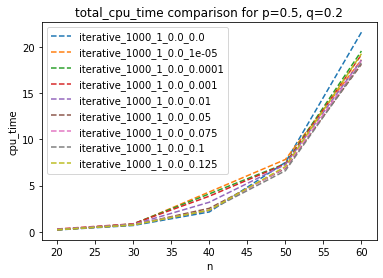

In [14]:
time_measure = 'total_cpu_time'
cpu_time_graph(time_measure, ignored_patterns, accepted_patterns, line_style, max_n)

## Gurobi CPU Time

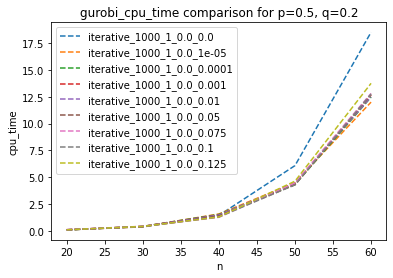

In [15]:
time_measure = 'gurobi_cpu_time'
cpu_time_graph(time_measure, ignored_patterns, accepted_patterns, line_style, max_n)

## Proportion CPU Time Gurobi

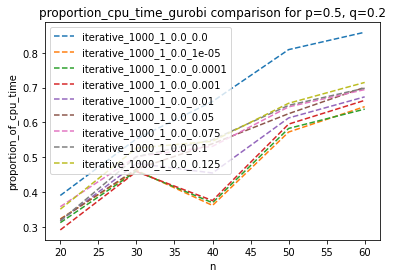

In [16]:
time_measure = 'proportion_cpu_time_gurobi'
cpu_time_graph(time_measure, ignored_patterns, accepted_patterns, line_style, max_n)

## Number of Max Constraints

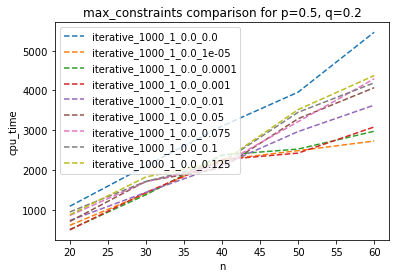

In [17]:
time_measure = 'max_constraints'
cpu_time_graph(time_measure, ignored_patterns, accepted_patterns, line_style, max_n)

## Number of LP's per Solve

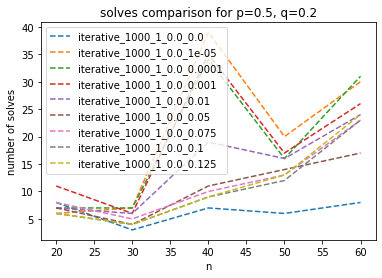

In [19]:
# count number of runs
gd = run.groupby(['p', 'q', 'solve_type', 'cut_value', 'min_search_proportion', 'threshold_proportion',
                  'act_tol', 'n'])['sub_solve_id'].max().reset_index()

# create id
gd['idx'] = gd['solve_type'] + '_' + gd['cut_value'].astype(str) + '_' + gd['min_search_proportion'].astype(str) + \
        '_' + gd['threshold_proportion'].astype(str) + '_' + gd['act_tol'].astype(str)

# rename and adjust for 0 indexing
gd.rename(columns={'sub_solve_id': 'solves'}, inplace=True)
gd['solves'] += 1

# filter graph data by data set
filters = {idx: gd['idx'] == idx for idx in gd['idx'].unique()}

# graph for each p, q combination 
for (p, q) in product(gd['p'].unique(), gd['q'].unique()):
    for name, fltr in filters.items():
        if any([ip in name for ip in ignored_patterns]) or (accepted_patterns and all([ap not in name for ap in accepted_patterns])):
            continue
        subset = gd.loc[(gd['p'] == p) & (gd['q'] == q) & fltr & (gd['n'] <= max_n)].sort_values('n')
        style = line_style.get(re.search('\w+_(.*)_.*_.*_.*', name).group(1), '-')
        plt.plot(subset['n'], subset['solves'], linestyle=style, label=name)

    plt.title(f'solves comparison for p={p}, q={q}')
    plt.ylabel('number of solves')
    plt.xlabel('n')
    plt.legend()
    plt.show()